# 데이터 로드

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 86 kB 7.2 MB/s 
     |████████████████████████████████| 448 kB 55.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
# 필요 프레임워크 및 라이브러리 준비
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# 사전에 정제+정규화된 훈련용 통합 데이터 로드
total_data = pd.read_table('clean_naver_shopping_review_total_data.txt')

In [6]:
# 통합 데이터 확인
print(len(total_data))

199908


In [7]:
print(total_data[:3])

   ratings                                           document  label
0        2                              입고다니기 좀그래요 실내에서만 입으세요      0
1        4  포장박스가 살짝오픈되어 있어서 조금 그랬는데 상품은 이상없었고 예상했던맛이며 공복에...      1
2        2         직원분 실수로 잘못 배달되어져서 간장소스거 와버렸죠그래도 와사비는 맛좋으네요      0


# 토큰화

In [8]:
# 불용어 정의 (한국어 조사, 접속사 등) 
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [9]:
# 훈련데이터에 형태소 분석기를 사용하여 토큰화를 하면서 불용어 제거
okt = Okt()
X_total = []
for sentence in total_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_total.append(temp_X)

In [10]:
print(len(X_total))
print(X_total[:3])

199908
[['입다', '그렇다', '실내', '에서만', '입다'], ['포장', '박스', '살짝', '오픈', '되어다', '있다', '조금', '그랬는데', '상품', '이상', '없다', '예상', '맛', '이며', '공복', '꼭꼭', '씹다', '먹다', '혈당', '빠르다', '올라가다', '않다', '만족스럽다'], ['직원', '분', '실수', '로', '잘못', '배달', '되어다', '간장', '소스', '거', '오다', '버리다', '그래도', '와사비', '맛', '좋다']]


# 정수 인코딩

In [11]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 데이터를 정수로 변환
# 일단 단어 집합을 만들자
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_total)
 # fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성한다.
 # 단어 빈도수가 높은순으로 낮은 정수 인덱스 부여

In [12]:
print(len(tokenizer.word_index))
print(tokenizer.word_index)
print(tokenizer.word_counts)

42467
{'좋다': 1, '너무': 2, '배송': 3, '요': 4, '보다': 5, '같다': 6, '있다': 7, '자다': 8, '안': 9, '먹다': 10, '재다': 11, '않다': 12, '구매': 13, '없다': 14, '이다': 15, '다': 16, '쓰다': 17, '오다': 18, '사용': 19, '되다': 20, '로': 21, '사다': 22, '을': 23, '그냥': 24, '제품': 25, '빠르다': 26, '가격': 27, '생각': 28, '받다': 29, '주문': 30, '맛': 31, '고': 32, '많이': 33, '하고': 34, '아니다': 35, '더': 36, '못': 37, '별로': 38, '때': 39, '만': 40, '것': 41, '사이즈': 42, 'ㅠㅠ': 43, '들다': 44, '만족하다': 45, '맛있다': 46, '에서': 47, '개': 48, '포장': 49, '써다': 50, '크다': 51, '네': 52, '편하다': 53, '그렇다': 54, '작다': 55, '맞다': 56, '서': 57, '거': 58, '상품': 59, '안되다': 60, '괜찮다': 61, '저렴하다': 62, '이쁘다': 63, 'ㅠ': 64, '넘다': 65, '싸다': 66, '정말': 67, '다른': 68, '냄새': 69, '부분': 70, '보내다': 71, '시키다': 72, '제': 73, '나다': 74, '나': 75, '인데': 76, '예쁘다': 77, '모르다': 78, '버리다': 79, 'ㅎㅎ': 80, '하나': 81, '이라': 82, '아주': 83, '두': 84, '진짜': 85, '감사하다': 86, '저': 87, '많다': 88, '되어다': 89, '구입': 90, '조금': 91, '또': 92, '좋아하다': 93, '반품': 94, '입다': 95, '아쉽다': 96, 'ㅜㅜ': 97, '쓸다': 98, '가다': 99, '딱': 100, 

In [20]:
# 등장 빈도수가 낮은 데이터를 처리해보자
# 특정 횟수 이하 단어의 비중이 몇인지 체크
threshold = 25
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42467
등장 빈도가 24번 이하인 희귀 단어의 수: 37138
단어 집합에서 희귀 단어의 비율: 87.45143287729296
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.975221975835322


In [21]:
# 전체 단어 개수 중 빈도수 12이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5330


In [22]:
# 단어집합을 케라스 토크나이저의 인자로 넘겨주면, 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환
#Tokenizer메서드에 숫자를 입력하면 빈도수가 높은 상위 몇개 단어만 사용
tokenizer = Tokenizer(num_words = vocab_size +2, oov_token ='OOV')
# 빈도수 상위 vocab_size단어만 사용, 숫자 0과 OOV를 고려해서 단어 집합의 크기는 +2
tokenizer.fit_on_texts(X_total)
# 여기까지는 보캡길이가 적용안된 것처럼 보임, 실제 적용은 text_to_sequences사용시 적용됨
X_total = tokenizer.texts_to_sequences(X_total)

# vocab_size로 지정한 단어만 보존하고 싶을 때, 굳이 안해도됨
# words_frequency = [w for w,c in tokenizer.word_index.items() if c >= vocab_size + 1] # 인덱스가 5 초과인 단어 제거
# for w in words_frequency:
#     del tokenizer.word_index[w] # 해당 단어에 대한 인덱스 정보를 삭제
#     del tokenizer.word_counts[w] # 해당 단어에 대한 카운트 정보를 삭제

# 정수인코딩 결과 확인
print(len(tokenizer.word_index))
print(tokenizer.word_index)
print(tokenizer.word_counts)

# 빈도수 상위 vocabsize개수의 단어는 2 ~ vocabsize+1까지의 인덱스를 가졌으며, 그 외 단어 집합에 없는 단어들은 전부 'OOV'의 인덱스인 1로 인코딩
# 케라스 토크나이저는 기본적으로 'OOV'의 인덱스를 1로 지정
# print('단어 OOV의 인덱스 : {}'.format(tokenizer.word_index['OOV']))

42468
{'OOV': 1, '좋다': 2, '너무': 3, '배송': 4, '요': 5, '보다': 6, '같다': 7, '있다': 8, '자다': 9, '안': 10, '먹다': 11, '재다': 12, '않다': 13, '구매': 14, '없다': 15, '이다': 16, '다': 17, '쓰다': 18, '오다': 19, '사용': 20, '되다': 21, '로': 22, '사다': 23, '을': 24, '그냥': 25, '제품': 26, '빠르다': 27, '가격': 28, '생각': 29, '받다': 30, '주문': 31, '맛': 32, '고': 33, '많이': 34, '하고': 35, '아니다': 36, '더': 37, '못': 38, '별로': 39, '때': 40, '만': 41, '것': 42, '사이즈': 43, 'ㅠㅠ': 44, '들다': 45, '만족하다': 46, '맛있다': 47, '에서': 48, '개': 49, '포장': 50, '써다': 51, '크다': 52, '네': 53, '편하다': 54, '그렇다': 55, '작다': 56, '맞다': 57, '서': 58, '거': 59, '상품': 60, '안되다': 61, '괜찮다': 62, '저렴하다': 63, '이쁘다': 64, 'ㅠ': 65, '넘다': 66, '싸다': 67, '정말': 68, '다른': 69, '냄새': 70, '부분': 71, '보내다': 72, '시키다': 73, '제': 74, '나다': 75, '나': 76, '인데': 77, '예쁘다': 78, '모르다': 79, '버리다': 80, 'ㅎㅎ': 81, '하나': 82, '이라': 83, '아주': 84, '두': 85, '진짜': 86, '감사하다': 87, '저': 88, '많다': 89, '되어다': 90, '구입': 91, '조금': 92, '또': 93, '좋아하다': 94, '반품': 95, '입다': 96, '아쉽다': 97, 'ㅜㅜ': 98, '쓸다': 99, '가다': 100

In [23]:
y_total = np.array(total_data['label'])

# 빈 샘플(empty samples)제거

In [24]:
# 각 샘플의 길이가 0인 샘플들의 인덱스 확인
drop_total = [index for index, sentence in enumerate(X_total) if len(sentence) < 1]
print(drop_total)

[155188, 170664]


In [25]:
# 빈 샘플들을 제거
X_total = np.delete(X_total, drop_total, axis=0)
y_total = np.delete(y_total, drop_total, axis=0)
print(len(X_total))
print(len(y_total))

199906
199906


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩

리뷰의 최대 길이 : 61
리뷰의 평균 길이 : 12.086950866907447


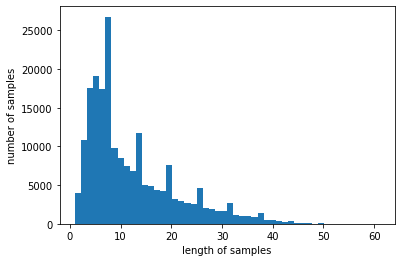

In [26]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰는 작업
# 전체 데이터에서 가장 길이가 긴 리뷰와, 전체의 길이분포를 알아보자
print('리뷰의 최대 길이 :',max(len(l) for l in X_total))
print('리뷰의 평균 길이 :',sum(map(len, X_total))/len(X_total))
plt.hist([len(s) for s in X_total], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
# 최적의 길이를 찾기 위해, 전체 샘플중 길이가 max_len 이하인 샘플의 비율을 확인하는 함수 생성
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [29]:
# 비율 체크
max_len = 30
below_threshold_len(max_len, X_total)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.69600712334797


In [30]:
# 짧은 데이터는 0을 채우고, 35을 넘는 긴 데이터는 손실됨
X_total = pad_sequences(X_total, maxlen = max_len)

# LSTM/GRU/BiLSTM 모델 훈련

In [31]:
# 필요한 프레임워크 및 라이브러리 임포트
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [32]:
model_GRU = Sequential()
model_GRU.add(Embedding(vocab_size+2, 100))
model_GRU.add(GRU(128))
model_GRU.add(Dense(1, activation='sigmoid'))

In [33]:
# 검증 데이터 손실이 4회 증가하면 학습 조기 종료
# model check point를 사용하여 검증 데이터의 정확도가 이전보다 좋아질 경우만 모델 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc_GRU = ModelCheckpoint('RNN_GRU_KoNLPy(Okt)_Total(movie+shopping+game)_v0.3.1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [34]:
# 필요한 매트릭 선언, AUC-ROC, F1-Score, AUC-PR 에 필요한 지표 모두 체크
import tensorflow as tf

ROCauc = tf.keras.metrics.AUC(curve="ROC") # auc_1
PRauc = tf.keras.metrics.AUC(curve="PR") # auc_2
RECALL = tf.keras.metrics.Recall()
PRECISION = tf.keras.metrics.Precision()
TP = tf.keras.metrics.TruePositives()
TN = tf.keras.metrics.TrueNegatives()
FP = tf.keras.metrics.FalsePositives()
FN = tf.keras.metrics.FalseNegatives()

In [35]:
# GRU모델 훈련
model_GRU.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', ROCauc, PRauc, RECALL, PRECISION, TP, TN, FP, FN])
history = model_GRU.fit(X_total, y_total, epochs=15, callbacks=[es, mc_GRU], batch_size=100, validation_split=0.2)

Epoch 1/15
1600/1600 [==============================] - 28s 13ms/step - loss: 0.2797 - acc: 0.8915 - auc: 0.9509 - auc_1: 0.9428 - recall: 0.8965 - precision: 0.8877 - true_positives: 71757.0000 - true_negatives: 70811.0000 - false_positives: 9074.0000 - false_negatives: 8282.0000 - val_loss: 0.2499 - val_acc: 0.9060 - val_auc: 0.9608 - val_auc_1: 0.9551 - val_recall: 0.9195 - val_precision: 0.8947 - val_true_positives: 18310.0000 - val_true_negatives: 17914.0000 - val_false_positives: 2156.0000 - val_false_negatives: 1602.0000

Epoch 00001: val_acc improved from -inf to 0.90601, saving model to RNN_GRU_KoNLPy(Okt)_Total(movie+shopping+game)_v0.3.1.h5
Epoch 2/15
1600/1600 [==============================] - 19s 12ms/step - loss: 0.2339 - acc: 0.9112 - auc: 0.9649 - auc_1: 0.9594 - recall: 0.9182 - precision: 0.9056 - true_positives: 73491.0000 - true_negatives: 72224.0000 - false_positives: 7661.0000 - false_negatives: 6548.0000 - val_loss: 0.2359 - val_acc: 0.9104 - val_auc: 0.9645 - v

# 모델 성능평가

In [36]:
# 평가용 토탈 데이터셋2(화장품+앱)

# 데이터 로드
total_data2 = pd.read_table('clean_total_data(app&cosmetic).txt')

# 토크나이징
X_test_total2 = []
for sentence in total_data2['document']:
    temp_X2 = okt.morphs(sentence, stem=True)
    temp_X2 = [word for word in temp_X2 if not word in stopwords]
    X_test_total2.append(temp_X2)

# 워드 벡터화
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_test_total2)
X_test_total2 = tokenizer.texts_to_sequences(X_test_total2)

# 패딩
X_test_total2 = pad_sequences(X_test_total2, maxlen = max_len)

# 라벨데이터 포함
y_test_total2 = np.array(total_data2['label'])

In [37]:
# GRU모델 성능 평가 
loaded_model = load_model('RNN_GRU_KoNLPy(Okt)_Total(movie+shopping+game)_v0.3.1.h5')
result = loaded_model.evaluate(X_test_total2, y_test_total2, batch_size=100)
print("\n GRU 테스트 결과:",result)

107/107 [==============================] - 2s 6ms/step - loss: 1.2401 - acc: 0.5171 - auc: 0.5377 - auc_1: 0.7169 - recall: 0.5023 - precision: 0.7249 - true_positives: 3745.0000 - true_negatives: 1750.0000 - false_positives: 1421.0000 - false_negatives: 3711.0000

 GRU 테스트 결과: [1.2400604486465454, 0.5170791149139404, 0.5376877188682556, 0.716903567314148, 0.502280056476593, 0.7249322533607483, 3745.0, 1750.0, 1421.0, 3711.0]
